# Reprojecting to other coordinate system:

Reproject GCM from lat-lon to x-y coordinates system so as to share same system as RCM.

## Setting up:
Run some scripts that install missing libraries.

In [ ]:
# run script that installs missing libraries
! chmod 755 scripts.sh
! scripts.sh

### Imports:

In [2]:
import os
import sys
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs
import gcsfs
from tqdm import tqdm
import pyproj
from pyproj import Transformer
from google.cloud import storage
from re import search
from os import listdir
from os.path import isfile, join

from Process_pangeo_GCM import *
from GC_scripts import *
from Process_RCM import *
from Reproject_GCM import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Google cloud:
Set up google cloud where data is stored

In [3]:
# Google cloud info
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Read data:

Read GCM data in lat-lon coordiantes and RCM data in stereographic.

### GCM lat-lon:

In [4]:
"""
# If want to read GCM file from pangeo, but not the one we used in the end
# Connect to Google Cloud Storage
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Read catalogue
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip5.csv")

# Create dataframe from function:
dg = createGCM_Pangeo(df,fs)
dg"""

'\n# Connect to Google Cloud Storage\nfs = gcsfs.GCSFileSystem(token=\'anon\', access=\'read_only\')\n\n# Read catalogue\ndf = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip5.csv")\n\n# Create dataframe from function:\ndg = createGCM_Pangeo(df,fs)\ndg'

In [5]:
# upload to GC:
print("Downloading from GC...")
name = f"ACCESS1-3_monthly_aus.nc"
pathLocal = "../../../data/tmp/"
pathGC = f"Chris_data/RawData/ACCESS1.3/monthly/"
downloadFileFromGC(pathGC, pathLocal, name)

# delete file and temporary directory:
GCM = xr.open_dataset(pathLocal + name)
os.remove(pathLocal + name)

In [6]:
GCM

<xarray.Dataset>
Dimensions:  (lat: 41, time: 1452, lon: 192)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... -42.5 -41.25 -40.0
  * time     (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    huss     (time, lat, lon) float32 ...
    hurs     (time, lat, lon) float32 ...
    pr       (time, lat, lon) float32 ...
    evspsbl  (time, lat, lon) float32 ...
    tas      (time, lat, lon) float32 ...
    ps       (time, lat, lon) float32 ...
    rsds     (time, lat, lon) float32 ...
    rlds     (time, lat, lon) float32 ...
    vas      (time, lat, lon) float32 ...
    uas      (time, lat, lon) float32 ...
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

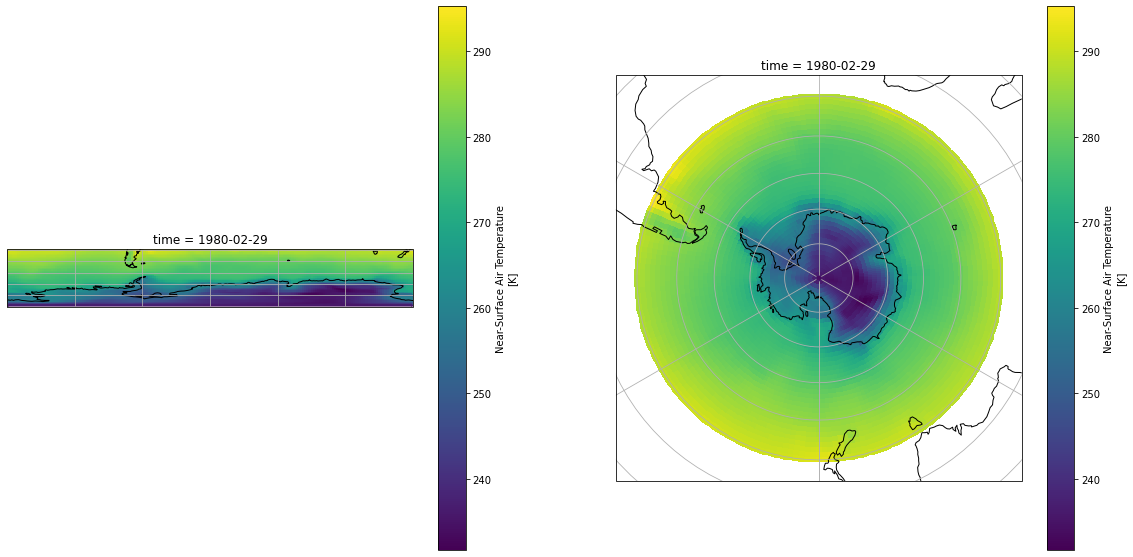

In [7]:
# Plot in both projections
f = plt.figure(figsize=(20, 10))
map_proj = ccrs.PlateCarree(central_longitude=0)
ax = plt.subplot(1, 2, 1, projection=map_proj)
GCM.tas.isel(time=1).plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 2, 2, projection=map_proj)
GCM.tas.isel(time=1).plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())  # data
ax.coastlines()
ax.gridlines()

### RCM x-y:

In [8]:
# open from google cloud
VAR = "CC"
(pathGC, fileGC) = pathToFiles(VAR, date1="19800101", date2="19801231")
downloadFileFromGC(pathGC, "", fileGC)
RCM_xy = BasicPreprocRCM(ProcessRCMVar(VAR, xr.open_dataset(fileGC)))

os.remove(fileGC)
dates = pd.DatetimeIndex(RCM_xy.time.values)
print("Unique years in the dataset:", dates.year.unique().values)

printMaxMin_XY(RCM_xy.x, RCM_xy.y, unit="m")

RCM_xy

Unique years in the dataset: [1980]
Max and min values of x: -3010000.00m -> 3115000.00m and y: -2555000.00m -> 2590000.00m


<xarray.Dataset>
Dimensions:      (time: 366, y: 148, x: 176)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-31T12:...
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Data variables:
    CC           (time, y, x) float32 ...
Attributes: (12/21)
    CDI:                            Climate Data Interface version 1.9.7.1 (h...
    Conventions:                    CF-1.6
    history:                        Mon Mar  7 12:02:39 2022: ncap2 -O -s CC=...
    institute:                      University of Liege (Belgium)
    contact:                        ckittel@uliege.be
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    ...                             ...
    frequency:                      day
    institute_id:                   ULg
    institution:                    University of Liege - Belgium
    model_id:                       ULg-MAR311
    product:                        output
    reference:                      http://www.climato.be

## Transform GCM lat/lon -> x/y:

Want to upsample RCM grid so that it goes from resolution of 35km to 150km

### Create upsampled RCM grid:
To change GCM resolution from degrees to km use formula:

x = deg_lon * distance between lon lines at point

y = deg_lat * distance between lat lines at point

Take d(lon) at -60°lat is 55km and d(lat) at -60°lat is 110km ([Link](https://stevemorse.org/nearest/distance.php))

Then x = 68km and y = 206km

In [9]:
# Create upsampled RCM grid on which we'll interpolate GCM
resx = 90
resy = 32
grid = False
gridx, gridy = create_downs_RCMgrid(grid=grid, resx = resx, resy = resy)

Original RCM grid:
----------------------
Max and min values of x: -3010.00km -> 3115.00km and y: -2555.00km -> 2590.00km
shape: (148, 176)
resolution: (35.0, 35.0)
bounds: (-3027.5, 2607.5, 3132.5, -2572.5)
CRS: EPSG:3031

Downsample to new resolution:
----------------------
Max and min values of x: -5848.00km -> 6052.00km and y: -15038.00km -> 15244.00km
shape: (148, 176)
resolution: (68.0, 205.99998671343536)
bounds: (-5882.0, 15346.999016794218, 6086.0, -15140.999016794218)
CRS: EPSG:3031

Cut so that on original x,y bounds:
--------------------------
Max and min values of x: -2992.00km -> 3060.00km and y: -2472.00km -> 2472.00km
New grid shape (gridx, gridy): (90,) (25,)


### Interpolate GCM on upsampled RCM grid:

In [19]:
print('\n---------------------------------\nRight part:\n---------------------------------\n')
GCM_xy_right = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = False)
print('\n---------------------------------\nLeft part:\n---------------------------------\n')
GCM_xy_left = InterpolateGCM(GCM, RCM_xy, gridx, gridy, left = True)

# Assemble two parts:
GCM_xy = GCM_xy_right.merge(GCM_xy_left)


---------------------------------
Right part:
---------------------------------

Shape of GCM data: time: 1452, lat: 41, lon: 192
-----------------
Shape of RCM data: time: 366, y: 148, x: 176
-----------------
Mesh shapes: (25, 90), (25, 90)
Lat-lon mesh:
-----------------
Max and min values of lat: -90.00° -> -54.89° and lon: -178.42° -> 180.00°

Interpolate:

GCM before interpolation:
-----------------
Max and min values of lat: -90.00° -> -40.00° and lon: 0.00° -> 358.12°

GCM after interpolation
-----------------
Max and min values of lat: -90.00° -> -54.89° and lon: -178.42° -> 180.00°

Replace coordinates by new coordinates:

---------------------------------
Left part:
---------------------------------

After transf
Max and min values of lat: -90.00° -> -40.00° and lon: -180.00° -> 178.12°
Shape of GCM data: time: 1452, lat: 41, lon: 192
-----------------
Shape of RCM data: time: 366, y: 148, x: 176
-----------------
Mesh shapes: (25, 90), (25, 90)
Lat-lon mesh:
--------------

In [20]:
GCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, y: 25, x: 90)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    huss         (time, y, x) float32 0.005407 0.004989 ... 0.004609 0.004609
    hurs         (time, y, x) float32 85.44 83.57 85.48 ... 86.39 85.96 85.96
    pr           (time, y, x) float32 4.555e-05 4.826e-05 ... 2.891e-05
    evspsbl      (time, y, x) float32 1.458e-05 1.738e-05 ... 1.329e-05
    tas          (time, y, x) float32 280.1 279.2 279.0 ... 277.0 277.6 277.6
    ps           (time, y, x) float32 1.002e+05 1.001e+05 ... 9.877e+04
    rsds         (time, y, x) float32 198.7 185.6 185.7 ... 229.4 237.2 237.2
    rlds         (time, y, x) float32 323.4 322.4 322.1 ... 304.2 304.9 304.9
    vas          (time, y, x) float32 -1.286 -0.5397 -0.9289 ... -0.7237 -0.7237
    uas          (time, y, x) float32 4.281 3.95 3.241 ... 4.711 5.572 5.572
    spatial_ref  int64 0
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    epsg:4326

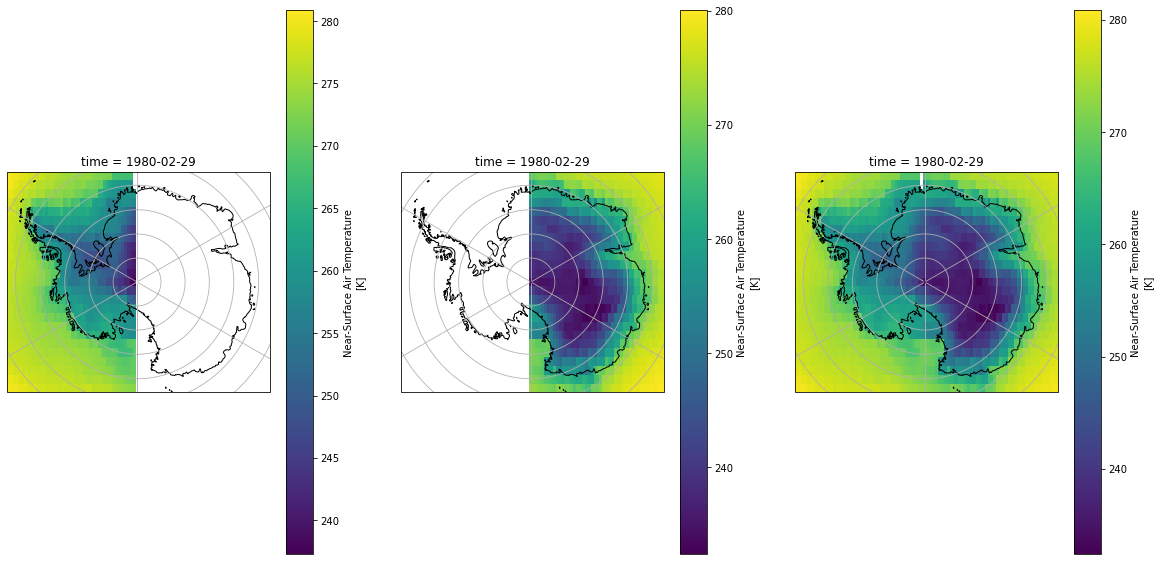

In [21]:
f = plt.figure(figsize=(20, 10))

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 3, 2, projection=map_proj)
GCM_xy_right.tas.isel(time=1).plot(
    ax=ax, x="x", y="y", transform=ccrs.SouthPolarStereo()
)
# data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 3, 1, projection=map_proj)
GCM_xy_left.tas.isel(time=1).plot(
    ax=ax, x="x", y="y", transform=ccrs.SouthPolarStereo()
)
# data
ax.coastlines()
ax.gridlines()

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 3, 3, projection=map_proj)
GCM_xy.tas.isel(time=1).plot(ax=ax, x="x", y="y", transform=ccrs.SouthPolarStereo())
# data
ax.coastlines()
ax.gridlines()

### Interpolate missing values:
See that there is a small streak that misses values, interpolate to fill them with linear interpoplation.

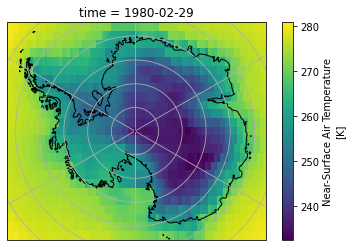

In [22]:
GCM_xy = GCM_xy.interpolate_na(dim="x", method="linear", fill_value="extrapolate")

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.subplot(1, 1, 1, projection=map_proj)
GCM_xy.tas.isel(time=1).plot(ax=ax, x="x", y="y", transform=ccrs.SouthPolarStereo())
# data
ax.coastlines()
ax.gridlines()

### Save new projection to GC:

In [23]:
# Save file
if grid:
    name = f"ACCESS1-3-stereographic_monthly_{resx}x{resy}.nc"
else:
    name = "ACCESS1-3-stereographic_monthly.nc"

# save file locally:
GCM_xy.attrs["crs"] = 3031
GCM_xy.to_netcdf(name)

# upload to GC:
print(f"Uploading {name} to GC....")
pathGC = f"Chris_data/RawData/MAR-ACCESS1.3/monthly/GCM/"
uploadFileToGC(pathGC, name)
os.remove(name)

Uploading ACCESS1-3-stereographic_monthly.nc to GC....


In [24]:
GCM_xy

<xarray.Dataset>
Dimensions:      (time: 1452, x: 90, y: 25)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2100-12-31
  * x            (x) float32 -2.992e+06 -2.924e+06 ... 2.992e+06 3.06e+06
  * y            (y) float32 -2.472e+06 -2.266e+06 ... 2.266e+06 2.472e+06
Data variables:
    huss         (time, y, x) float32 0.005407 0.004989 ... 0.004609 0.004609
    hurs         (time, y, x) float32 85.44 83.57 85.48 ... 86.39 85.96 85.96
    pr           (time, y, x) float32 4.555e-05 4.826e-05 ... 2.891e-05
    evspsbl      (time, y, x) float32 1.458e-05 1.738e-05 ... 1.329e-05
    tas          (time, y, x) float32 280.1 279.2 279.0 ... 277.0 277.6 277.6
    ps           (time, y, x) float32 1.002e+05 1.001e+05 ... 9.877e+04
    rsds         (time, y, x) float32 198.7 185.6 185.7 ... 229.4 237.2 237.2
    rlds         (time, y, x) float32 323.4 322.4 322.1 ... 304.2 304.9 304.9
    vas          (time, y, x) float32 -1.286 -0.5397 -0.9289 ... -0.7237 -0.7237
    uas          (time, y, x) float32 4.281 3.95 3.241 ... 4.711 5.572 5.572
    spatial_ref  int64 0
Attributes: (12/29)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0
    crs:                    3031